In [1]:
import random
import json
from skimage.color import rgb2hsv
from tqdm import tqdm
from imgaug import augmenters as iaa
from imgaug import Keypoint, KeypointsOnImage
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
caminho_para_json = '/content/drive/MyDrive/A de Agro/keypoints.json'
with open(caminho_para_json, 'r') as arquivo:
    dados_keypoints = json.load(arquivo)

caminho_para_imagens = '/content/drive/MyDrive/A de Agro/images/images'

dados_imagem = []
dicionario_keypoints = {anotacao['image_id']: anotacao for anotacao in dados_keypoints['annotations']}
categorias = {cat['id']: cat for cat in dados_keypoints['categories']}

for id_imagem, nome_imagem in tqdm(list(dados_keypoints['images'].items())):
    if int(id_imagem) in dicionario_keypoints:
        dados = dicionario_keypoints[int(id_imagem)]
        caminho_imagem = f'{caminho_para_imagens}/{nome_imagem}'
        try:
            imagem = Image.open(caminho_imagem)
        except:
            pass
        np_imagem = np.array(imagem)

        detalhes_categoria = categorias[dados['category_id']]

        info_imagem = {
            'caminho_imagem': caminho_imagem,
            'np_imagem': np_imagem,
            'keypoints': dados['keypoints'],
            'bbox': dados['bbox'],
            'category_id': dados['category_id'],
            'nome_categoria': detalhes_categoria['name'],
            'nomes_keypoints': detalhes_categoria['keypoints'],
            'skeleton': detalhes_categoria['skeleton']
        }
        dados_imagem.append(info_imagem)


100%|██████████| 4608/4608 [00:14<00:00, 308.24it/s]


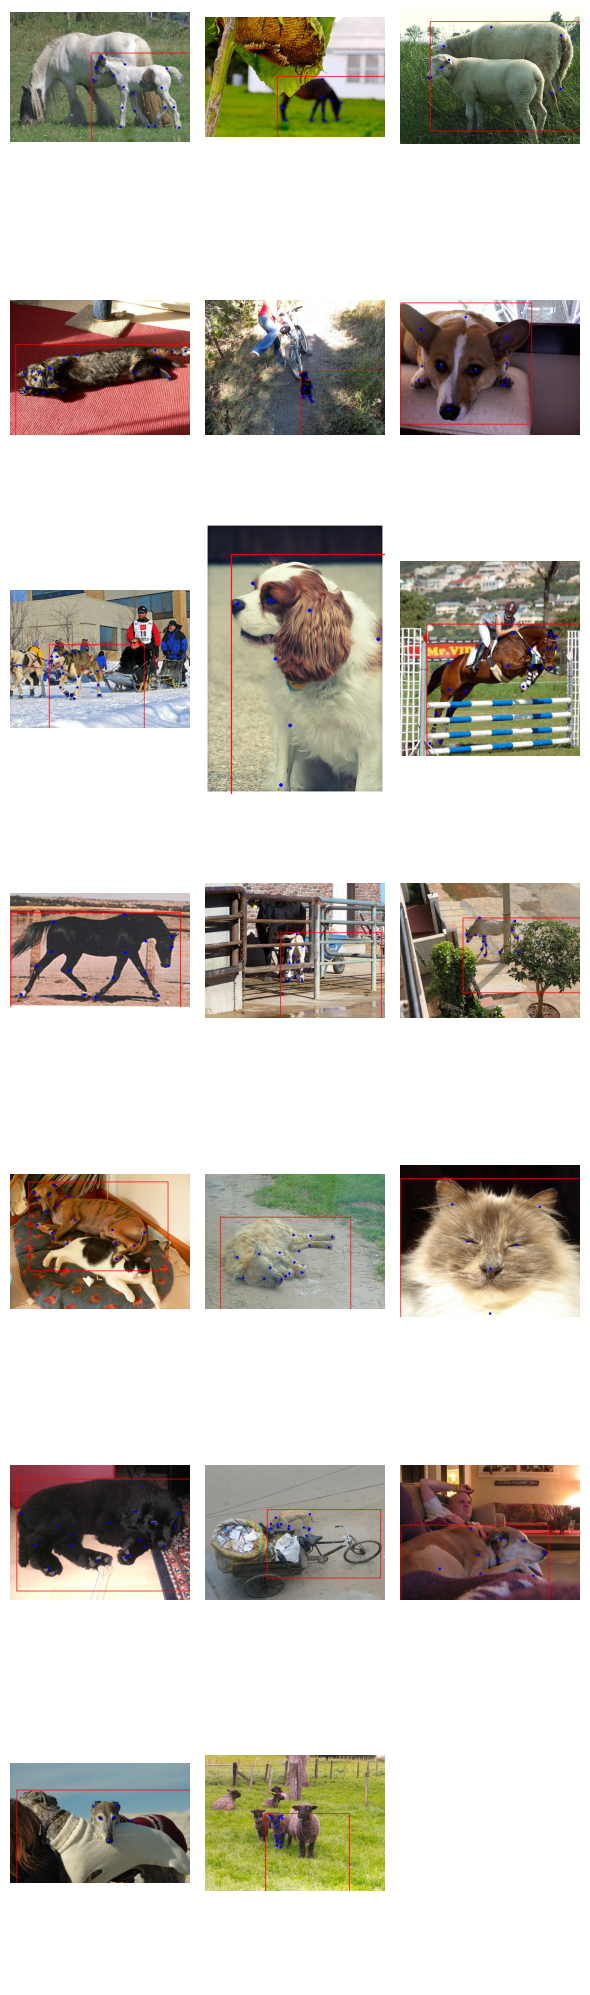

In [6]:
imagens_por_linha = 3
N = 20

imagens_amostradas = random.sample(dados_imagem, N)
num_linhas = N // imagens_por_linha + (N % imagens_por_linha > 0)

fig, axes = plt.subplots(num_linhas, imagens_por_linha, figsize=(2 * imagens_por_linha, 3 * num_linhas))

axes = axes.flatten() if num_linhas > 1 else [axes]

def desenhar_keypoints_e_bbox(draw, keypoints, bbox):
    bbox_retangulo = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
    draw.rectangle(bbox_retangulo, outline="red", width=2)

    for x, y, v in keypoints:
        if v == 1:
            draw.ellipse((x - 3, y - 3, x + 3, y + 3), fill='blue')

for idx, (dados, ax) in enumerate(zip(imagens_amostradas, axes)):
    array_imagem = dados['np_imagem']
    imagem = Image.fromarray(array_imagem)
    draw = ImageDraw.Draw(imagem)

    desenhar_keypoints_e_bbox(draw, dados['keypoints'], dados['bbox'])

    ax.imshow(imagem)
    ax.axis('off')

if N < num_linhas * imagens_por_linha:
    for ax in axes[N:]:
        ax.axis('off')

plt.tight_layout()
plt.show()


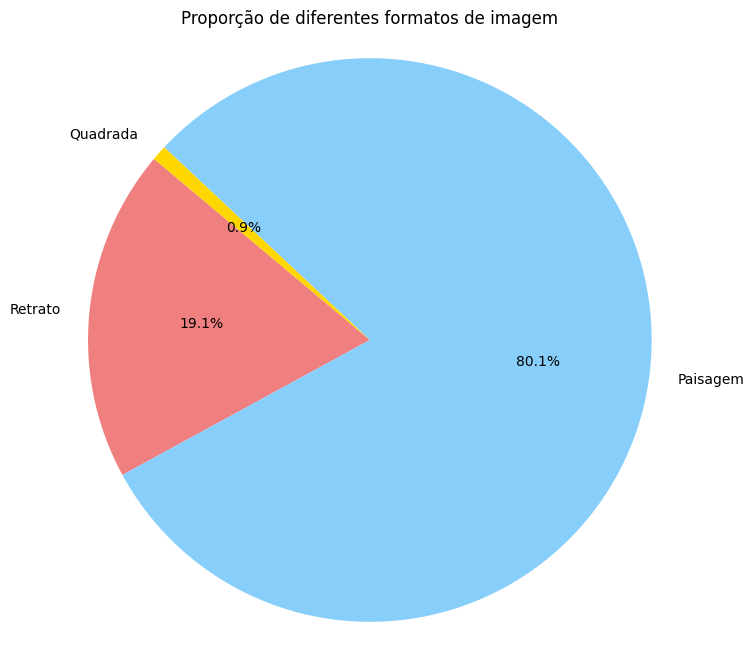

In [8]:
larguras = [img['np_imagem'].shape[1] for img in dados_imagem]
alturas = [img['np_imagem'].shape[0] for img in dados_imagem]

contagem_retrato = sum(1 for h, w in zip(alturas, larguras) if h > w)
contagem_paisagem = sum(1 for h, w in zip(alturas, larguras) if h < w)
contagem_quadrada = sum(1 for h, w in zip(alturas, larguras) if h == w)

labels = ['Retrato', 'Paisagem', 'Quadrada']
tamanhos = [contagem_retrato, contagem_paisagem, contagem_quadrada]
cores = ['lightcoral', 'lightskyblue', 'gold']

plt.figure(figsize=(8, 8))
plt.pie(tamanhos, labels=labels, colors=cores, autopct='%1.1f%%', startangle=140)
plt.title('Proporção de diferentes formatos de imagem')
plt.axis('equal')
plt.show()


In [10]:
categorias = keypoints_data['categories']

for categoria in categorias:
    print(f"ID: {categoria['id']}, Nome: {categoria['name']}, Supercategoria: {categoria['supercategory']}")


ID: 1, Name: dog, Supercategory: animal
ID: 2, Name: cat, Supercategory: animal
ID: 3, Name: sheep, Supercategory: animal
ID: 4, Name: horse, Supercategory: animal
ID: 5, Name: cow, Supercategory: animal


In [14]:
imagens_bovinas = [dados for dados in dados_imagem if dados['category_id'] == 5]
print(f"Total de imagens: {len(dados_imagem)}")
print(f"Total de imagens de bovinos (vacas): {len(imagens_bovinas)}")


Total de imagens: 4608
Total de imagens de bovinos (vacas): 532


In [16]:

def preprocess_and_augment(image_info, output_size=(400, 400), max_keypoints=19):
    image = image_info['np_image']
    keypoints = image_info['keypoints']

    seq = iaa.Sequential([
        iaa.Resize({"height": output_size[1], "width": output_size[0]}),
        iaa.Fliplr(0.5),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25)
        )
    ], random_order=True)

    keypoints_ia = [Keypoint(x=point[0], y=point[1]) for point in keypoints if point[2] > 0]
    keypoints_on_image = KeypointsOnImage(keypoints_ia, shape=image.shape)

    image_aug, keypoints_aug = seq(image=image, keypoints=keypoints_on_image)
    image_aug = image_aug / 255.0

    keypoints_normalized = [(kp.x / output_size[0], kp.y / output_size[1]) for kp in keypoints_aug.keypoints]
    while len(keypoints_normalized) < max_keypoints:
        keypoints_normalized.append((0, 0))

    return image_aug, np.array(keypoints_normalized).flatten()

In [17]:
max_keypoints = max(len(item['keypoints']) for item in bovine_images)
x_train = []
y_train = []

for item in tqdm(bovine_images):
    processed_image, processed_keypoints = preprocess_and_augment(item, max_keypoints=max_keypoints)
    x_train.append(processed_image)
    y_train.append(processed_keypoints)

x_train = np.array(x_train)
y_train = np.array(y_train)


100%|██████████| 532/532 [00:07<00:00, 66.78it/s]


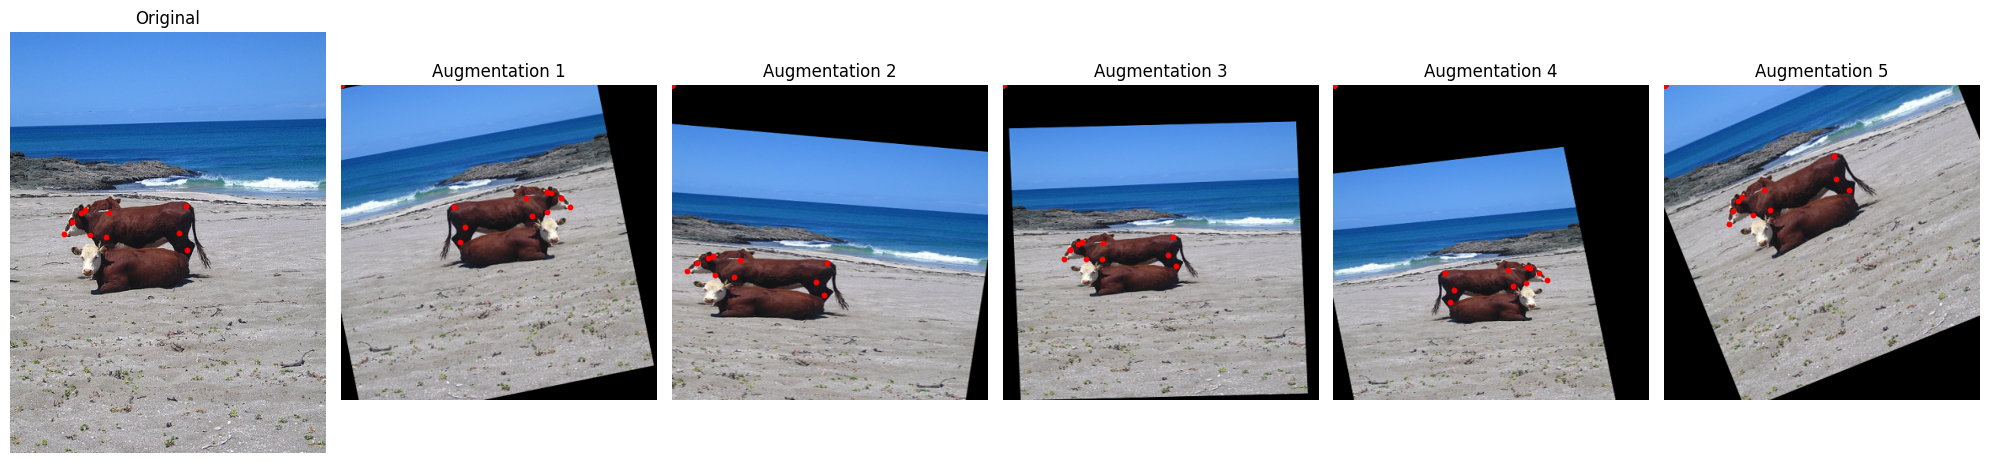

In [18]:
def preprocessamento_e_aumentacao(dados_imagem, tamanho_saida=(400, 400), max_keypoints=19):
    imagem = dados_imagem['np_imagem']
    keypoints = dados_imagem['keypoints']

    seq = iaa.Sequential([
        iaa.Resize({"height": tamanho_saida[1], "width": tamanho_saida[0]}),
        iaa.Fliplr(0.5),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25)
        )
    ], random_order=True)

    keypoints_ia = [Keypoint(x=ponto[0], y=ponto[1]) for ponto in keypoints if ponto[2] > 0]
    keypoints_na_imagem = KeypointsOnImage(keypoints_ia, shape=imagem.shape)

    imagem_aumentada, keypoints_aumentados = seq(image=imagem, keypoints=keypoints_na_imagem)
    imagem_aumentada = imagem_aumentada / 255.0

    keypoints_normalizados = [(kp.x / tamanho_saida[0], kp.y / tamanho_saida[1]) for kp in keypoints_aumentados.keypoints]
    while len(keypoints_normalizados) < max_keypoints:
        keypoints_normalizados.append((0, 0))

    return imagem_aumentada, np.array(keypoints_normalizados).flatten()
